In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gambar-test/L.jpg
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/augmented_image_80.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/flip131.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/flip069.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/rotate011.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/flip098.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/flip083.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/augmented_image_39.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/rotate141.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/flip001.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/augmented_image_72.txt
/kaggle/input/indonesian-sign-language-bisindo/bisindo/labels/val/N/image_22.txt
/kaggle/input/indonesian-sign-language-bisindo/bis

In [3]:
# 1. IMPORT LIBRARY & SETUP KAGGLE
# ============================================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import random
import json
import sys
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

print(f" TensorFlow {tf.__version__}")
print(f" Keras {keras.__version__}")

# Konfigurasi plot
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True
sns.set_style("whitegrid")

 TensorFlow 2.18.0
 Keras 3.8.0


In [4]:
# 2. SETUP DATASET PATH - DENGAN DETEKSI OTOMATIS
# ============================================
print("\n" + "="*80)
print("DETEKSI DAN SETUP DATASET")
print("="*80)

# Cari dataset di /kaggle/input
dataset_folders = [f for f in os.listdir('/kaggle/input') if os.path.isdir(os.path.join('/kaggle/input', f))]
print(f" Dataset tersedia: {dataset_folders}")

# Pilih dataset yang mengandung "bisindo" atau "sign"
selected_dataset = None
for folder in dataset_folders:
    if 'bisindo' in folder.lower() or 'sign' in folder.lower():
        selected_dataset = folder
        break

if not selected_dataset and dataset_folders:
    selected_dataset = dataset_folders[0]  # Ambil yang pertama

if not selected_dataset:
    print("❌ Tidak ada dataset ditemukan!")
    sys.exit(1)

BASE_PATH = f"/kaggle/input/{selected_dataset}"
print(f"Menggunakan dataset: {selected_dataset}")
print(f"Base path: {BASE_PATH}")


DETEKSI DAN SETUP DATASET
 Dataset tersedia: ['gambar-test', 'indonesian-sign-language-bisindo']
Menggunakan dataset: indonesian-sign-language-bisindo
Base path: /kaggle/input/indonesian-sign-language-bisindo


In [5]:
# Cari struktur folder
def find_data_paths(base_path):
    """Cari path untuk images/train dan images/val"""
    possible_structures = [
        ("images/train", "images/val"),
        ("train", "val"),
        ("train/images", "val/images"),
        ("data/train", "data/val"),
        ("training", "testing"),
        ("Training", "Testing")
    ]
    
    for train_struct, val_struct in possible_structures:
        train_path = os.path.join(base_path, train_struct)
        val_path = os.path.join(base_path, val_struct)
        
        if os.path.exists(train_path) and os.path.exists(val_path):
            # Cek apakah ada subfolder (kelas) di dalamnya
            train_subfolders = [f for f in os.listdir(train_path) 
                              if os.path.isdir(os.path.join(train_path, f))]
            if train_subfolders:
                return train_path, val_path
    
    # Cari secara rekursif
    train_found, val_found = None, None
    for root, dirs, files in os.walk(base_path):
        if "train" in root.lower():
            # Cek apakah ini folder kelas atau berisi subfolder kelas
            for d in dirs:
                if len(d) == 1 and d.isalpha():  # A, B, C, dll
                    train_found = root
                    break
        if "val" in root.lower() or "test" in root.lower():
            for d in dirs:
                if len(d) == 1 and d.isalpha():
                    val_found = root
                    break
    
    return train_found, val_found

TRAIN_PATH, VAL_PATH = find_data_paths(BASE_PATH)

if not TRAIN_PATH:
    print(" Folder training tidak ditemukan!")
    # Tampilkan struktur untuk debugging
    print("\n Struktur folder yang ada:")
    for root, dirs, files in os.walk(BASE_PATH):
        level = root.replace(BASE_PATH, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for d in dirs[:5]:  # Tampilkan 5 subfolder pertama
            print(f'{subindent}{d}/')
        if level > 2:  # Batasi depth
            break
    sys.exit(1)

print(f"\n Path ditemukan:")
print(f"  • TRAIN_PATH: {TRAIN_PATH}")
print(f"  • VAL_PATH: {VAL_PATH}")


 Path ditemukan:
  • TRAIN_PATH: /kaggle/input/indonesian-sign-language-bisindo/bisindo/images/train
  • VAL_PATH: /kaggle/input/indonesian-sign-language-bisindo/bisindo/images/val



 ANALISIS DATASET LENGKAP

 STATISTIK DETAIL DATASET:

  TRAINING:
    • Jumlah kelas: 26
    • Total gambar: 9169
    • Rata-rata per kelas: 352.7
    • Min per kelas: 328
    • Max per kelas: 360
    • Std deviasi: 7.2
    • Kelas (10 pertama): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']...

  VALIDATION:
    • Jumlah kelas: 26
    • Total gambar: 2301
    • Rata-rata per kelas: 88.5
    • Min per kelas: 83
    • Max per kelas: 90
    • Std deviasi: 1.7
    • Kelas (10 pertama): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']...

 KONFIGURASI DATASET:
  • Jumlah kelas: 26
  • Total gambar training: 9169
  • Total gambar validation: 2301


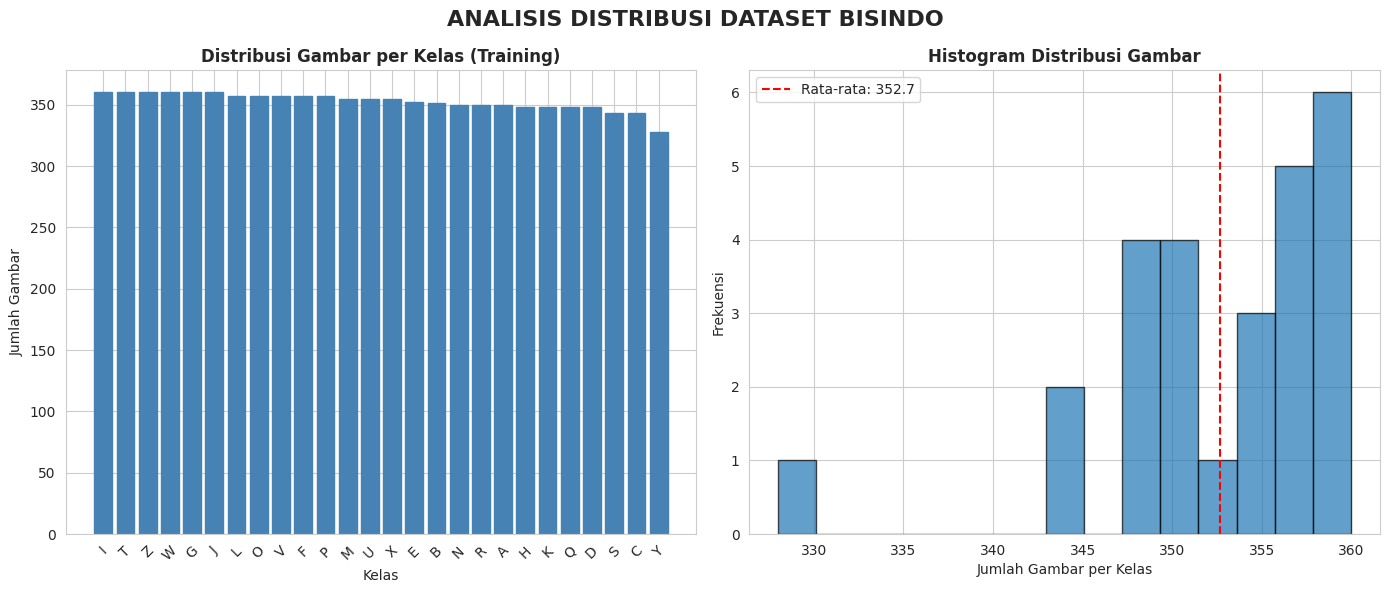

In [7]:
# 3. ANALISIS DATASET LENGKAP
# ============================================
print("\n" + "="*80)
print(" ANALISIS DATASET LENGKAP")
print("="*80)

def analyze_dataset_comprehensive(train_path, val_path):
    """Analisis dataset secara komprehensif"""
    results = {}
    
    for name, path in [("Training", train_path), ("Validation", val_path)]:
        if not os.path.exists(path):
            continue
            
        class_counts = {}
        total_images = 0
        class_folders = []
        
        # Ambil semua folder kelas
        for item in os.listdir(path):
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                # Hitung gambar
                images = [f for f in os.listdir(item_path) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
                class_counts[item] = len(images)
                total_images += len(images)
                class_folders.append(item)
        
        # Hitung statistik
        if class_counts:
            avg_per_class = total_images / len(class_counts)
            min_images = min(class_counts.values())
            max_images = max(class_counts.values())
            std_images = np.std(list(class_counts.values()))
        else:
            avg_per_class = min_images = max_images = std_images = 0
        
        results[name.lower()] = {
            "total": total_images,
            "num_classes": len(class_counts),
            "classes": sorted(class_folders),
            "class_counts": class_counts,
            "avg_per_class": avg_per_class,
            "min_images": min_images,
            "max_images": max_images,
            "std_images": std_images
        }
    
    return results

dataset_stats = analyze_dataset_comprehensive(TRAIN_PATH, VAL_PATH)

print("\n STATISTIK DETAIL DATASET:")
for name, stats in dataset_stats.items():
    print(f"\n  {name.upper()}:")
    print(f"    • Jumlah kelas: {stats['num_classes']}")
    print(f"    • Total gambar: {stats['total']}")
    print(f"    • Rata-rata per kelas: {stats['avg_per_class']:.1f}")
    print(f"    • Min per kelas: {stats['min_images']}")
    print(f"    • Max per kelas: {stats['max_images']}")
    print(f"    • Std deviasi: {stats['std_images']:.1f}")
    print(f"    • Kelas (10 pertama): {stats['classes'][:10]}{'...' if len(stats['classes']) > 10 else ''}")

NUM_CLASSES = dataset_stats.get('training', {}).get('num_classes', 26)
TOTAL_TRAIN_IMAGES = dataset_stats.get('training', {}).get('total', 0)
TOTAL_VAL_IMAGES = dataset_stats.get('validation', {}).get('total', 0)

print(f"\n KONFIGURASI DATASET:")
print(f"  • Jumlah kelas: {NUM_CLASSES}")
print(f"  • Total gambar training: {TOTAL_TRAIN_IMAGES}")
print(f"  • Total gambar validation: {TOTAL_VAL_IMAGES}")

# Visualisasi distribusi kelas
if dataset_stats.get('training', {}).get('class_counts'):
    train_counts = dataset_stats['training']['class_counts']
    df_train = pd.DataFrame(list(train_counts.items()), columns=['Kelas', 'Jumlah'])
    df_train = df_train.sort_values('Jumlah', ascending=False)
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    bars = plt.bar(df_train['Kelas'], df_train['Jumlah'])
    plt.title('Distribusi Gambar per Kelas (Training)', fontweight='bold')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45)
    
    # Warna berdasarkan jumlah
    for bar in bars:
        bar.set_color('steelblue')
    
    plt.subplot(1, 2, 2)
    plt.hist(df_train['Jumlah'], bins=15, edgecolor='black', alpha=0.7)
    plt.title('Histogram Distribusi Gambar', fontweight='bold')
    plt.xlabel('Jumlah Gambar per Kelas')
    plt.ylabel('Frekuensi')
    plt.axvline(df_train['Jumlah'].mean(), color='red', linestyle='--', 
                label=f'Rata-rata: {df_train["Jumlah"].mean():.1f}')
    plt.legend()
    
    plt.suptitle('ANALISIS DISTRIBUSI DATASET BISINDO', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [15]:
# 4. PREPROCESSING DAN DATA GENERATOR
# ============================================
print("\n" + "="*80)
print(" PREPROCESSING DAN DATA GENERATOR")
print("="*80)

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS_TUNING = 15  # Untuk hyperparameter tuning
EPOCHS_FINAL = 30   # Untuk training final

print(f"  Parameter Data:")
print(f"  • Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"  • Batch size: {BATCH_SIZE}")

# Data augmentation lengkap
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print(f"\n Data Generator Berhasil:")
print(f"  • Training samples: {train_generator.samples}")
print(f"  • Validation samples: {val_generator.samples}")
print(f"  • Number of classes: {train_generator.num_classes}")
print(f"  • Class indices: {train_generator.class_indices}")

# Simpan class indices untuk nanti
class_indices = train_generator.class_indices


 PREPROCESSING DAN DATA GENERATOR
  Parameter Data:
  • Image size: 128x128
  • Batch size: 32
Found 9169 images belonging to 26 classes.
Found 2301 images belonging to 26 classes.

 Data Generator Berhasil:
  • Training samples: 9169
  • Validation samples: 2301
  • Number of classes: 26
  • Class indices: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [10]:
# 5. FUNGSI MODEL DENGAN PARAMETER YANG DAPAT DIKONFIGURASI
# ============================================
def create_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                     num_classes=NUM_CLASSES,
                     optimizer='adam',
                     learning_rate=0.001,
                     regularization='l2',
                     dropout_rate=0.5,
                     use_batch_norm=True):
    """
    Membuat model CNN dengan parameter yang dapat dikonfigurasi
    untuk hyperparameter tuning
    """
    print(f"\n Membuat model dengan:")
    print(f"   • Optimizer: {optimizer}")
    print(f"   • Learning rate: {learning_rate}")
    print(f"   • Regularization: {regularization}")
    print(f"   • Dropout: {dropout_rate}")
    print(f"   • Batch Normalization: {use_batch_norm}")
    
    # Pilih regularizer
    if regularization == 'l2':
        kernel_reg = regularizers.l2(0.001)
    elif regularization == 'l1':
        kernel_reg = regularizers.l1(0.001)
    elif regularization == 'l1_l2':
        kernel_reg = regularizers.l1_l2(l1=0.001, l2=0.001)
    else:
        kernel_reg = None
    
    model = models.Sequential(name="BISINDO_CNN_Tuned")
    
    # Blok Konvolusi 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=input_shape,
                           kernel_regularizer=kernel_reg,
                           padding='same'))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Blok Konvolusi 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu',
                           kernel_regularizer=kernel_reg,
                           padding='same'))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Blok Konvolusi 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu',
                           kernel_regularizer=kernel_reg,
                           padding='same'))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Blok Konvolusi 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu',
                           kernel_regularizer=kernel_reg,
                           padding='same'))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Fully Connected Layers
    model.add(layers.Flatten())
    
    model.add(layers.Dense(512, activation='relu',
                          kernel_regularizer=kernel_reg))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(256, activation='relu',
                          kernel_regularizer=kernel_reg))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Pilih optimizer
    if optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer.lower() == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=0.9)
    elif optimizer.lower() == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    else:
        opt = Adam(learning_rate=learning_rate)
    
    # Compile model dengan multiple metrics
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

In [11]:
# 6. HYPERPARAMETER TUNING LENGKAP
# ============================================
print("\n" + "="*80)
print(" HYPERPARAMETER TUNING LENGKAP")
print("="*80)

def run_hyperparameter_tuning(train_gen, val_gen, num_classes):
    """
    Menjalankan eksperimen hyperparameter tuning
    dengan berbagai kombinasi
    """
    print(f" Menjalankan hyperparameter tuning...")
    print(f"   • Training samples: {train_gen.samples}")
    print(f"   • Validation samples: {val_gen.samples}")
    print(f"   • Number of classes: {num_classes}")
    
    # Definisikan kombinasi hyperparameter
    hyperparameter_combinations = [
        # Eksperimen 1-3: Adam dengan regularisasi berbeda
        {
            'name': 'Exp1-Adam-L2',
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'regularization': 'l2',
            'dropout_rate': 0.5,
            'use_batch_norm': True
        },
        {
            'name': 'Exp2-Adam-L1',
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'regularization': 'l1',
            'dropout_rate': 0.5,
            'use_batch_norm': True
        },
        {
            'name': 'Exp3-Adam-NoReg',
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'regularization': None,
            'dropout_rate': 0.5,
            'use_batch_norm': True
        },
        # Eksperimen 4-5: Optimizer berbeda
        {
            'name': 'Exp4-RMSprop-L2',
            'optimizer': 'rmsprop',
            'learning_rate': 0.001,
            'regularization': 'l2',
            'dropout_rate': 0.5,
            'use_batch_norm': True
        },
        {
            'name': 'Exp5-SGD-L2',
            'optimizer': 'sgd',
            'learning_rate': 0.01,
            'regularization': 'l2',
            'dropout_rate': 0.5,
            'use_batch_norm': True
        },
        # Eksperimen 6-7: Learning rate berbeda
        {
            'name': 'Exp6-Adam-L2-LowLR',
            'optimizer': 'adam',
            'learning_rate': 0.0001,
            'regularization': 'l2',
            'dropout_rate': 0.5,
            'use_batch_norm': True
        },
        {
            'name': 'Exp7-Adam-L2-HighLR',
            'optimizer': 'adam',
            'learning_rate': 0.01,
            'regularization': 'l2',
            'dropout_rate': 0.5,
            'use_batch_norm': True
        },
        # Eksperimen 8-9: Dropout rate berbeda
        {
            'name': 'Exp8-Adam-L2-LowDropout',
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'regularization': 'l2',
            'dropout_rate': 0.3,
            'use_batch_norm': True
        },
        {
            'name': 'Exp9-Adam-L2-HighDropout',
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'regularization': 'l2',
            'dropout_rate': 0.7,
            'use_batch_norm': True
        }
    ]
    
    results = []
    histories = []
    
    for i, params in enumerate(hyperparameter_combinations):
        print(f"\n{'='*50}")
        print(f" EKSPERIMEN {i+1}/{len(hyperparameter_combinations)}: {params['name']}")
        print(f"{'='*50}")
        
        # Buat model
        model = create_cnn_model(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
            num_classes=num_classes,
            optimizer=params['optimizer'],
            learning_rate=params['learning_rate'],
            regularization=params['regularization'],
            dropout_rate=params['dropout_rate'],
            use_batch_norm=params['use_batch_norm']
        )
        
        # Callbacks untuk tuning
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True,
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=0
            )
        ]
        
        # Training untuk tuning
        print(f"Training model...")
        history = model.fit(
            train_gen,
            epochs=EPOCHS_TUNING,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )
        
        # Simpan history
        histories.append(history)
        
        # Evaluasi
        eval_results = model.evaluate(val_gen, verbose=0)
        
        # Simpan hasil
        result = {
            'experiment': params['name'],
            'optimizer': params['optimizer'],
            'learning_rate': params['learning_rate'],
            'regularization': params['regularization'],
            'dropout_rate': params['dropout_rate'],
            'val_loss': eval_results[0],
            'val_accuracy': eval_results[1],
            'val_precision': eval_results[2] if len(eval_results) > 2 else 0,
            'val_recall': eval_results[3] if len(eval_results) > 3 else 0,
            'val_auc': eval_results[4] if len(eval_results) > 4 else 0,
            'epochs_trained': len(history.history['loss']),
            'best_val_accuracy': max(history.history['val_accuracy']),
            'best_val_loss': min(history.history['val_loss'])
        }
        
        results.append(result)
        
        print(f" Hasil {params['name']}:")
        print(f"   • Validation Accuracy: {result['val_accuracy']:.4f}")
        print(f"   • Validation Loss: {result['val_loss']:.4f}")
        print(f"   • Best Val Accuracy: {result['best_val_accuracy']:.4f}")
        print(f"   • Epochs Trained: {result['epochs_trained']}")
    
    # Konversi ke DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('val_accuracy', ascending=False)
    
    # Visualisasi hasil tuning
    visualize_tuning_results(results_df)
    
    return results_df, histories


 HYPERPARAMETER TUNING LENGKAP


In [12]:
def visualize_tuning_results(results_df):
    """Visualisasi hasil hyperparameter tuning"""
    print("\n VISUALISASI HASIL HYPERPARAMETER TUNING")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('HASIL HYPERPARAMETER TUNING - BISINDO CLASSIFICATION', 
                fontsize=16, fontweight='bold', y=1.02)
    
    # 1. Validation Accuracy
    ax1 = axes[0, 0]
    bars1 = ax1.barh(results_df['experiment'], results_df['val_accuracy'])
    ax1.set_xlabel('Validation Accuracy')
    ax1.set_title('Validation Accuracy per Eksperimen', fontweight='bold')
    ax1.axvline(results_df['val_accuracy'].max(), color='red', linestyle='--',
               alpha=0.7, label=f'Max: {results_df["val_accuracy"].max():.3f}')
    ax1.legend()
    
    # Warna bar terbaik
    max_idx = results_df['val_accuracy'].idxmax()
    for i, bar in enumerate(bars1):
        if i == max_idx:
            bar.set_color('green')
        else:
            bar.set_color('steelblue')
    
    # 2. Validation Loss
    ax2 = axes[0, 1]
    bars2 = ax2.barh(results_df['experiment'], results_df['val_loss'])
    ax2.set_xlabel('Validation Loss')
    ax2.set_title('Validation Loss per Eksperimen', fontweight='bold')
    ax2.axvline(results_df['val_loss'].min(), color='red', linestyle='--',
               alpha=0.7, label=f'Min: {results_df["val_loss"].min():.3f}')
    ax2.legend()
    
    # 3. Epochs Trained
    ax3 = axes[0, 2]
    bars3 = ax3.barh(results_df['experiment'], results_df['epochs_trained'])
    ax3.set_xlabel('Epochs Trained')
    ax3.set_title('Epochs Trained per Eksperimen', fontweight='bold')
    
    # 4. Learning Rate vs Accuracy
    ax4 = axes[1, 0]
    scatter = ax4.scatter(results_df['learning_rate'], results_df['val_accuracy'],
                         c=range(len(results_df)), cmap='viridis', s=200, alpha=0.7)
    ax4.set_xlabel('Learning Rate')
    ax4.set_ylabel('Validation Accuracy')
    ax4.set_title('Learning Rate vs Accuracy', fontweight='bold')
    ax4.set_xscale('log')
    
    # 5. Best Validation Accuracy
    ax5 = axes[1, 1]
    bars5 = ax5.barh(results_df['experiment'], results_df['best_val_accuracy'])
    ax5.set_xlabel('Best Validation Accuracy')
    ax5.set_title('Best Validation Accuracy', fontweight='bold')
    ax5.axvline(results_df['best_val_accuracy'].max(), color='red', linestyle='--',
               alpha=0.7, label=f'Max: {results_df["best_val_accuracy"].max():.3f}')
    ax5.legend()
    
    # 6. Precision vs Recall
    if 'val_precision' in results_df.columns and 'val_recall' in results_df.columns:
        ax6 = axes[1, 2]
        scatter2 = ax6.scatter(results_df['val_precision'], results_df['val_recall'],
                              c=results_df['val_auc'], cmap='coolwarm', s=200, alpha=0.7)
        ax6.set_xlabel('Precision')
        ax6.set_ylabel('Recall')
        ax6.set_title('Precision vs Recall (Color: AUC)', fontweight='bold')
        plt.colorbar(scatter2, ax=ax6, label='AUC')
    
    plt.tight_layout()
    plt.show()
    
    # Tampilkan hasil terbaik
    best_result = results_df.iloc[0]
    print(f"\n PARAMETER TERBAIK: {best_result['experiment']}")
    print(f"   • Validation Accuracy: {best_result['val_accuracy']:.4f}")
    print(f"   • Best Val Accuracy: {best_result['best_val_accuracy']:.4f}")
    print(f"   • Validation Loss: {best_result['val_loss']:.4f}")
    print(f"   • Optimizer: {best_result['optimizer']}")
    print(f"   • Learning Rate: {best_result['learning_rate']}")
    print(f"   • Regularization: {best_result['regularization']}")
    print(f"   • Dropout Rate: {best_result['dropout_rate']}")
    
    return best_result


 TRAINING MODEL FINAL DENGAN PARAMETER TERBAIK

 Memulai hyperparameter tuning...
 Menjalankan hyperparameter tuning...
   • Training samples: 9169
   • Validation samples: 2301
   • Number of classes: 26

 EKSPERIMEN 1/9: Exp1-Adam-L2

 Membuat model dengan:
   • Optimizer: adam
   • Learning rate: 0.001
   • Regularization: l2
   • Dropout: 0.5
   • Batch Normalization: True
Training model...
Epoch 1/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 112s 348ms/step - accuracy: 0.0801 - auc: 0.5793 - loss: 6.0180 - precision: 0.1204 - recall: 0.0182 - val_accuracy: 0.0391 - val_auc: 0.4950 - val_loss: 9.6791 - val_precision: 0.0403 - val_recall: 0.0387 - learning_rate: 0.0010
Epoch 2/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 87s 302ms/step - accuracy: 0.2387 - auc: 0.7851 - loss: 4.7832 - precision: 0.4839 - recall: 0.0855 - val_accuracy: 0.0813 - val_auc: 0.5372 - val_loss: 8.5483 - val_precision: 0.1026 - val_recall: 0.0669 - learning_rate: 0.0010
Epoch 3/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 90s 312ms/step - accur

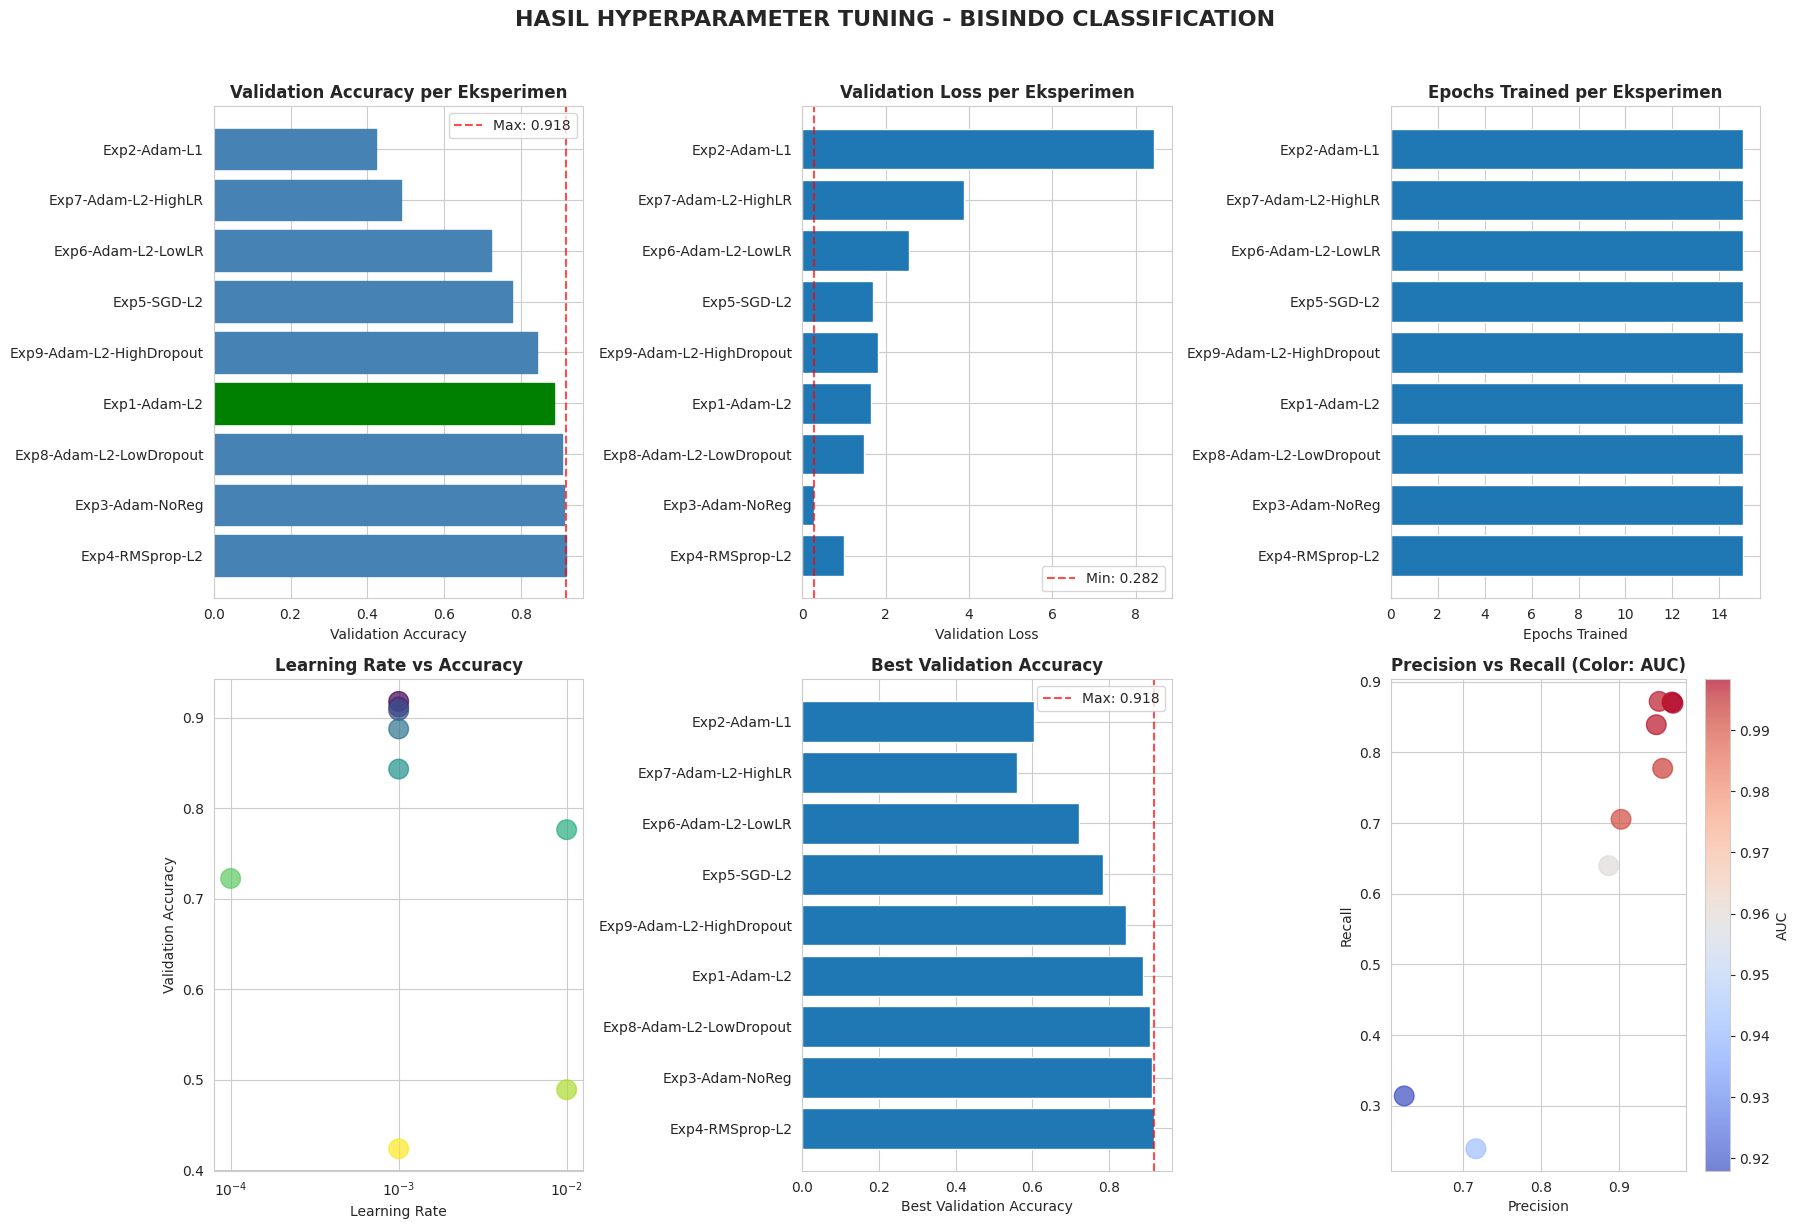


 PARAMETER TERBAIK: Exp4-RMSprop-L2
   • Validation Accuracy: 0.9179
   • Best Val Accuracy: 0.9179
   • Validation Loss: 1.0085
   • Optimizer: rmsprop
   • Learning Rate: 0.001
   • Regularization: l2
   • Dropout Rate: 0.5

 Parameter terbaik ditemukan: Exp4-RMSprop-L2

 Konfigurasi Model Final:
   • Optimizer: rmsprop
   • Learning Rate: 0.001
   • Regularization: l2
   • Dropout Rate: 0.5

 Membuat model dengan:
   • Optimizer: rmsprop
   • Learning rate: 0.001
   • Regularization: l2
   • Dropout: 0.5
   • Batch Normalization: True

 Memulai training model final (30 epochs)...
Epoch 1/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.1022 - auc: 0.6147 - loss: 5.8709 - precision: 0.1437 - recall: 0.0255
Epoch 1: val_accuracy improved from -inf to 0.03911, saving model to /kaggle/working/best_bisindo_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 110s 346ms/step - accuracy: 0.1023 - auc: 0.6149 - loss: 5.8696 - precision: 0.1440 - recall: 0.0256 - val_accuracy: 0.0391 - val_a

In [16]:
# 7. TRAINING MODEL FINAL DENGAN PARAMETER TERBAIK
# ============================================
print("\n" + "="*80)
print(" TRAINING MODEL FINAL DENGAN PARAMETER TERBAIK")
print("="*80)

# Jalankan hyperparameter tuning
print("\n Memulai hyperparameter tuning...")
tuning_results, tuning_histories = run_hyperparameter_tuning(
    train_generator, val_generator, NUM_CLASSES
)

# Ambil parameter terbaik
best_params = tuning_results.iloc[0]
print(f"\n Parameter terbaik ditemukan: {best_params['experiment']}")

def train_final_model(train_gen, val_gen, num_classes, best_params):
    """Training model final dengan parameter terbaik"""
    print(f"\n Konfigurasi Model Final:")
    print(f"   • Optimizer: {best_params['optimizer']}")
    print(f"   • Learning Rate: {best_params['learning_rate']}")
    print(f"   • Regularization: {best_params['regularization']}")
    print(f"   • Dropout Rate: {best_params['dropout_rate']}")
    
    # Buat model final
    final_model = create_cnn_model(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        num_classes=num_classes,
        optimizer=best_params['optimizer'],
        learning_rate=best_params['learning_rate'],
        regularization=best_params['regularization'],
        dropout_rate=best_params['dropout_rate'],
        use_batch_norm=True
    )
    
    # Callbacks untuk training final
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            filepath='/kaggle/working/best_bisindo_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]
    
    # Training model final
    print(f"\n Memulai training model final ({EPOCHS_FINAL} epochs)...")
    history_final = final_model.fit(
        train_gen,
        epochs=EPOCHS_FINAL,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )
    
    # Simpan model final
    final_model.save('/kaggle/working/final_bisindo_model.keras')
    print(f"\n Model final disimpan di: /kaggle/working/final_bisindo_model.keras")
    
    return final_model, history_final

# Training model final
final_model, final_history = train_final_model(
    train_generator, val_generator, NUM_CLASSES, best_params
)


 VISUALISASI HASIL TRAINING FINAL


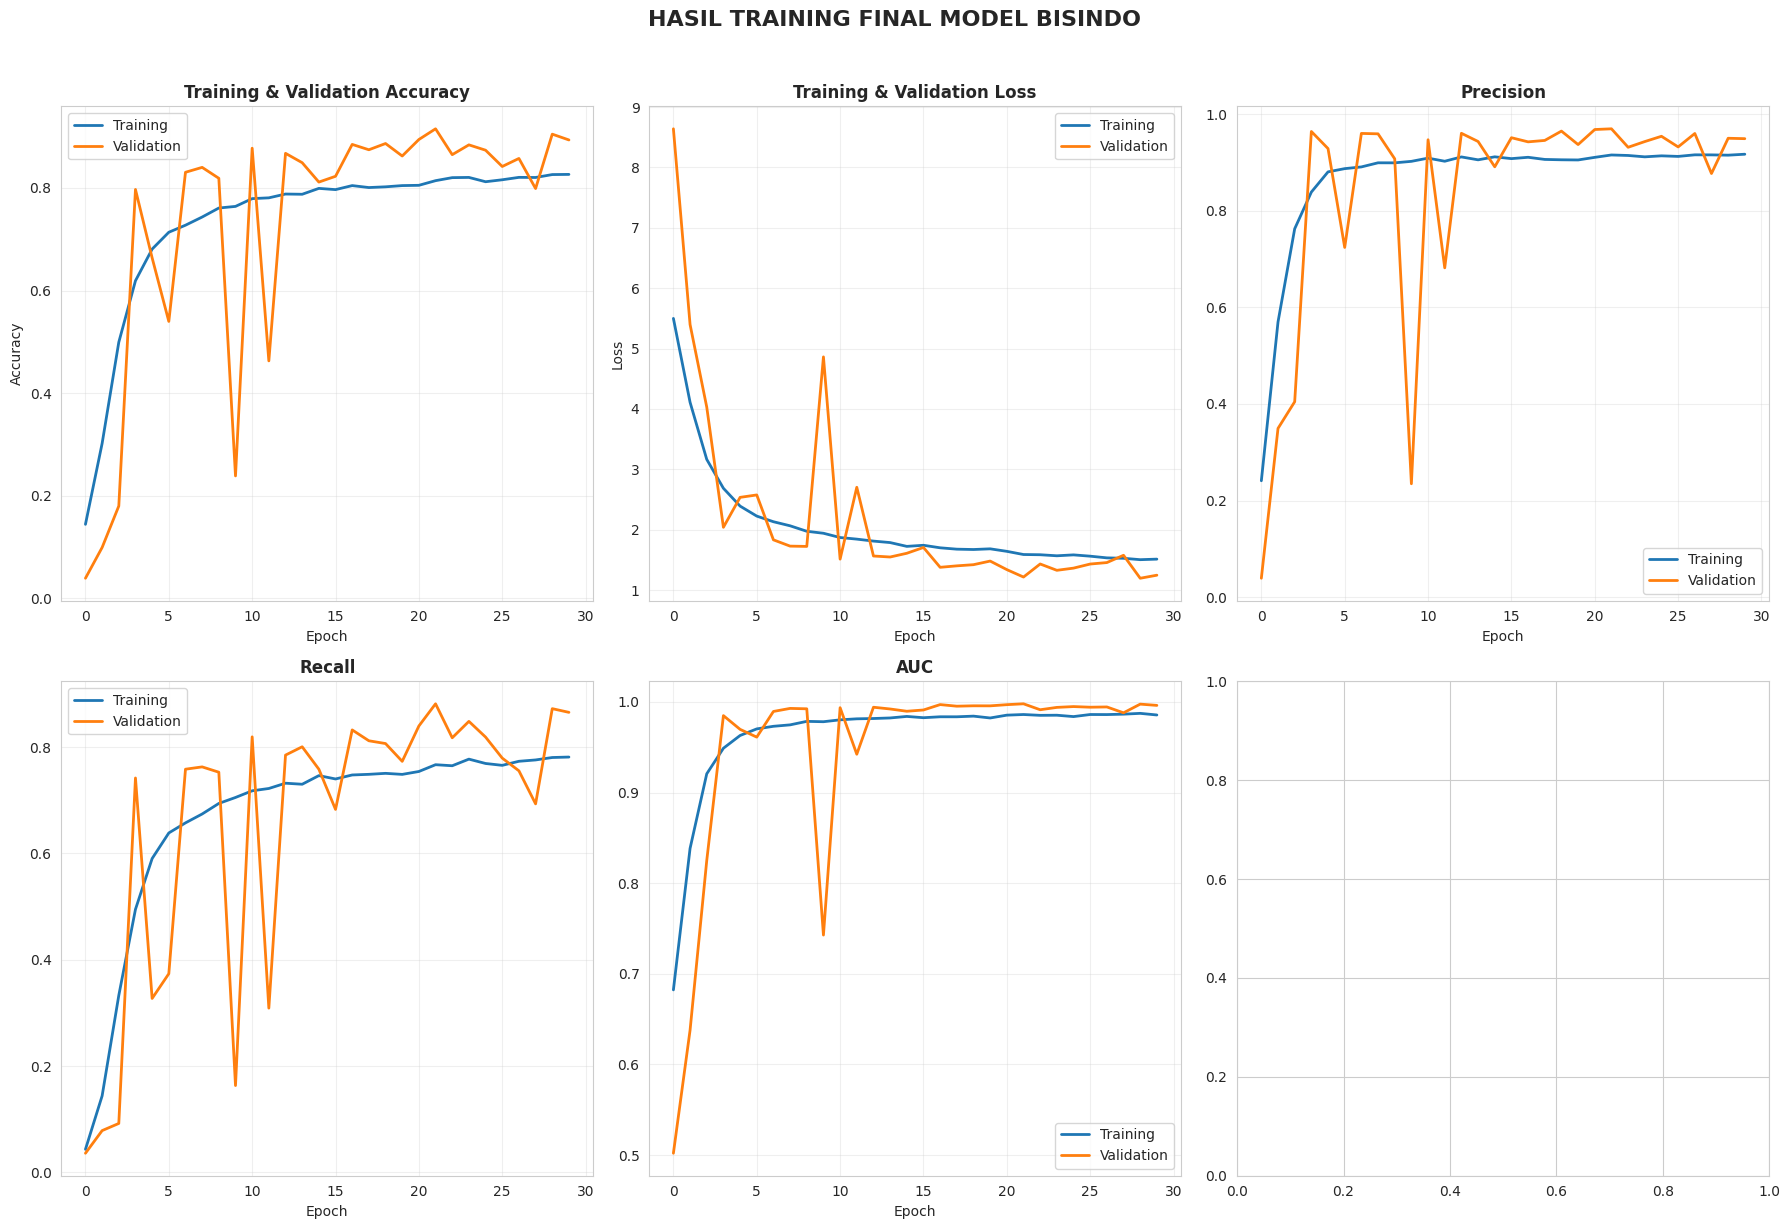


 STATISTIK TRAINING FINAL:
--------------------------------------------------
  • Final Training Accuracy: 0.8264
  • Final Validation Accuracy: 0.8935
  • Best Validation Accuracy: 0.9153
  • Final Training Loss: 1.5121
  • Final Validation Loss: 1.2460
  • Best Validation Loss: 1.1954
  • Epochs Trained: 30


In [19]:
# 8. VISUALISASI HASIL TRAINING FINAL
# ============================================
print("\n" + "="*80)
print(" VISUALISASI HASIL TRAINING FINAL")
print("="*80)

def visualize_final_training(history):
    """Visualisasi hasil training final"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Training & Validation Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Training & Validation Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    if 'precision' in history.history:
        axes[0, 2].plot(history.history['precision'], label='Training', linewidth=2)
        axes[0, 2].plot(history.history['val_precision'], label='Validation', linewidth=2)
        axes[0, 2].set_title('Precision', fontweight='bold')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    
    # Recall
    if 'recall' in history.history:
        axes[1, 0].plot(history.history['recall'], label='Training', linewidth=2)
        axes[1, 0].plot(history.history['val_recall'], label='Validation', linewidth=2)
        axes[1, 0].set_title('Recall', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # AUC
    if 'auc' in history.history:
        axes[1, 1].plot(history.history['auc'], label='Training', linewidth=2)
        axes[1, 1].plot(history.history['val_auc'], label='Validation', linewidth=2)
        axes[1, 1].set_title('AUC', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    if 'lr' in history.history:
        axes[1, 2].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='green')
        axes[1, 2].set_title('Learning Rate Schedule', fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('LR')
        axes[1, 2].set_yscale('log')
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.suptitle('HASIL TRAINING FINAL MODEL BISINDO', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print statistik
    print("\n STATISTIK TRAINING FINAL:")
    print("-"*50)
    print(f"  • Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"  • Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"  • Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"  • Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"  • Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"  • Best Validation Loss: {min(history.history['val_loss']):.4f}")
    print(f"  • Epochs Trained: {len(history.history['accuracy'])}")

visualize_final_training(final_history)


 EVALUASI KOMPREHENSIF MODEL FINAL
 Mengevaluasi model final...

 METRIK EVALUASI:
  • loss: 1.1954
  • compile_metrics: 0.9048

 CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

           A     1.0000    0.8977    0.9461        88
           B     0.8854    0.9659    0.9239        88
           C     0.8557    0.9651    0.9071        86
           D     0.8058    0.9540    0.8737        87
           E     0.8600    0.9663    0.9101        89
           F     0.9149    0.9556    0.9348        90
           G     0.8095    0.9444    0.8718        90
           H     0.9560    1.0000    0.9775        87
           I     0.9375    0.8333    0.8824        90
           J     0.8916    0.8222    0.8555        90
           K     0.8901    0.9310    0.9101        87
           L     0.9302    0.8889    0.9091        90
           M     0.7683    0.7079    0.7368        89
           N     0.7347    0

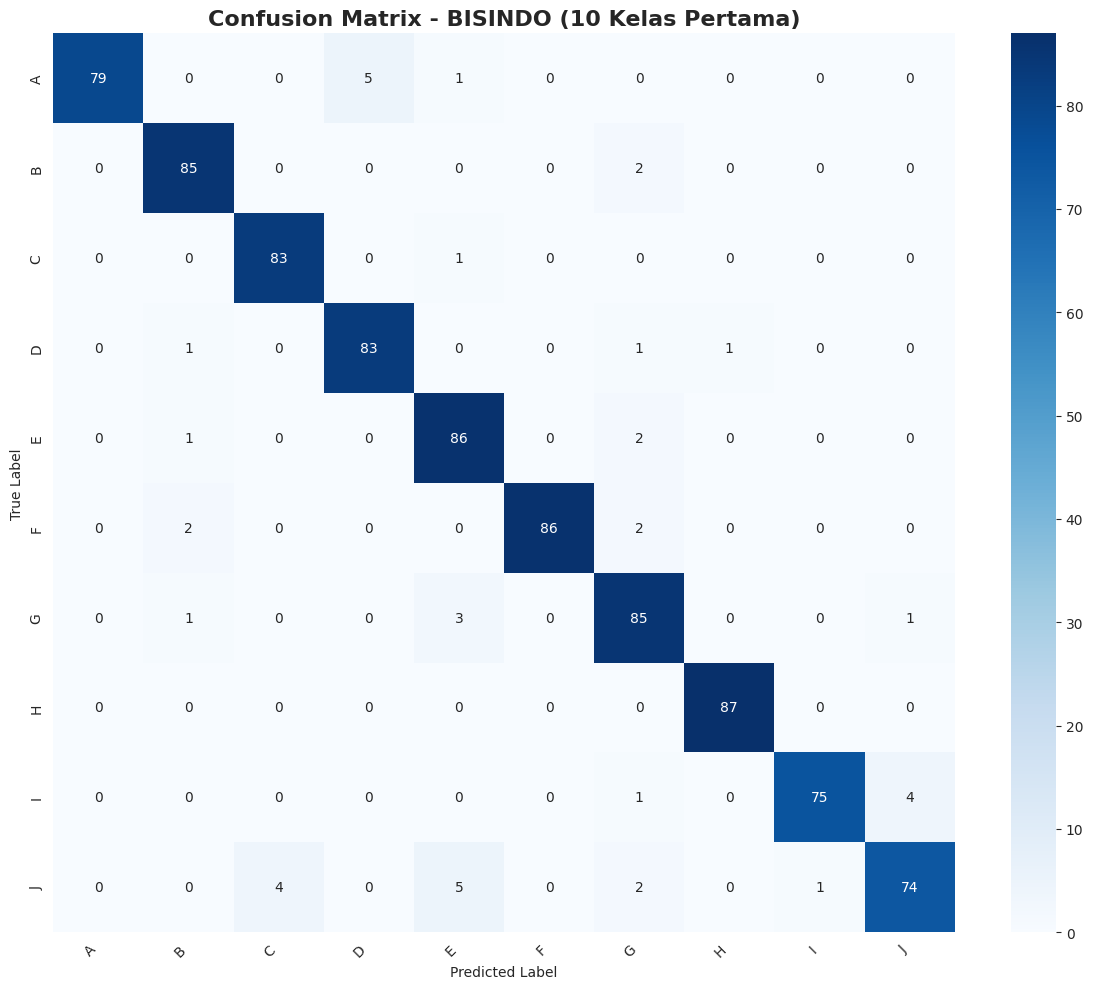


 AKURASI PER KELAS:
--------------------------------------------------
  • Rata-rata akurasi per kelas: 0.9049
  • Std deviasi: 0.0717
  • Akurasi terendah: 0.7079 (M)
  • Akurasi tertinggi: 1.0000 (H)


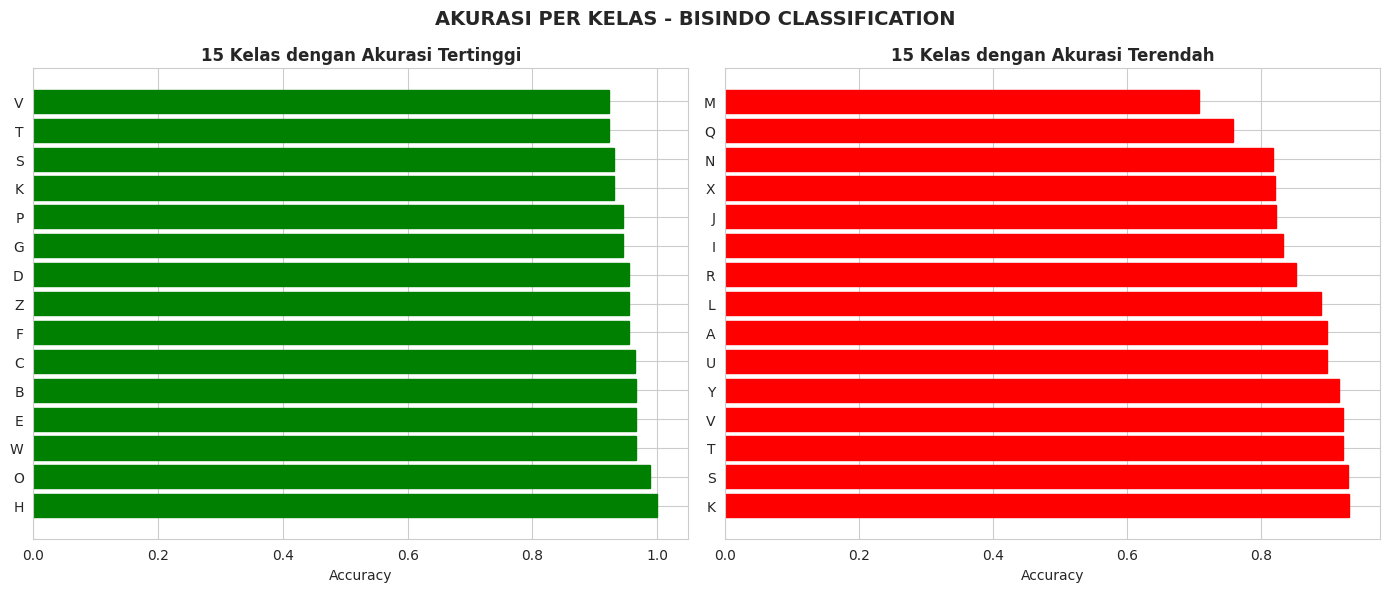

In [20]:
# 9. EVALUASI KOMPREHENSIF MODEL FINAL
# ============================================
print("\n" + "="*80)
print(" EVALUASI KOMPREHENSIF MODEL FINAL")
print("="*80)

def evaluate_model_comprehensive(model, val_gen, class_indices):
    """Evaluasi model secara komprehensif"""
    # Reset generator
    val_gen.reset()
    
    # Evaluasi standar
    eval_results = model.evaluate(val_gen, verbose=0)
    print("\n METRIK EVALUASI:")
    for name, value in zip(model.metrics_names, eval_results):
        print(f"  • {name}: {value:.4f}")
    
    # Prediksi
    val_gen.reset()
    y_pred = model.predict(val_gen, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_gen.classes
    
    # Classification report
    class_names = list(class_indices.keys())
    
    print(f"\n CLASSIFICATION REPORT:")
    print("-"*60)
    print(classification_report(y_true, y_pred_classes,
                              target_names=class_names,
                              digits=4))
    
    # Confusion Matrix
    print(f"\n CONFUSION MATRIX (10 Kelas Pertama):")
    cm = confusion_matrix(y_true, y_pred_classes)
    
    plt.figure(figsize=(12, 10))
    n_classes = min(10, len(class_names))
    sns.heatmap(cm[:n_classes, :n_classes], 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names[:n_classes],
                yticklabels=class_names[:n_classes])
    plt.title(f'Confusion Matrix - BISINDO ({n_classes} Kelas Pertama)', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Hitung akurasi per kelas
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    accuracy_df = pd.DataFrame({
        'Kelas': class_names,
        'Accuracy': per_class_accuracy,
        'Support': cm.sum(axis=1)
    }).sort_values('Accuracy', ascending=False)
    
    print(f"\n AKURASI PER KELAS:")
    print("-"*50)
    print(f"  • Rata-rata akurasi per kelas: {per_class_accuracy.mean():.4f}")
    print(f"  • Std deviasi: {per_class_accuracy.std():.4f}")
    print(f"  • Akurasi terendah: {per_class_accuracy.min():.4f} ({class_names[np.argmin(per_class_accuracy)]})")
    print(f"  • Akurasi tertinggi: {per_class_accuracy.max():.4f} ({class_names[np.argmax(per_class_accuracy)]})")
    
    # Visualisasi akurasi per kelas
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    top_15 = accuracy_df.head(15)
    bars1 = plt.barh(top_15['Kelas'], top_15['Accuracy'])
    plt.xlabel('Accuracy')
    plt.title('15 Kelas dengan Akurasi Tertinggi', fontweight='bold')
    for bar in bars1:
        bar.set_color('green')
    
    plt.subplot(1, 2, 2)
    bottom_15 = accuracy_df.tail(15)
    bars2 = plt.barh(bottom_15['Kelas'], bottom_15['Accuracy'])
    plt.xlabel('Accuracy')
    plt.title('15 Kelas dengan Akurasi Terendah', fontweight='bold')
    for bar in bars2:
        bar.set_color('red')
    
    plt.suptitle('AKURASI PER KELAS - BISINDO CLASSIFICATION', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return eval_results, accuracy_df

# Evaluasi model final
print(" Mengevaluasi model final...")
eval_results, accuracy_df = evaluate_model_comprehensive(final_model, val_generator, class_indices)

In [21]:
# 10. SIMPAN SEMUA HASIL DAN LAPORAN
# ============================================
print("\n" + "="*80)
print(" MENYIMPAN HASIL DAN LAPORAN")
print("="*80)

# Buat laporan lengkap
report = {
    "project_info": {
        "name": "Sistem Pengenalan Bahasa Isyarat BISINDO",
        "topic": "JST untuk Pengenalan Pola",
        "framework": "TensorFlow/Keras"
    },
    "dataset_info": {
        "name": selected_dataset,
        "train_path": TRAIN_PATH,
        "val_path": VAL_PATH,
        "train_samples": train_generator.samples,
        "val_samples": val_generator.samples,
        "num_classes": NUM_CLASSES,
        "class_names": list(class_indices.keys()),
        "class_indices": class_indices
    },
    "model_config": {
        "image_size": f"{IMG_HEIGHT}x{IMG_WIDTH}",
        "batch_size": BATCH_SIZE,
        "epochs_tuning": EPOCHS_TUNING,
        "epochs_final": EPOCHS_FINAL,
        "architecture": "CNN dengan 4 blok konvolusi",
        "total_parameters": final_model.count_params()
    },
    "best_hyperparameters": {
        "experiment": best_params['experiment'],
        "optimizer": best_params['optimizer'],
        "learning_rate": float(best_params['learning_rate']),
        "regularization": best_params['regularization'],
        "dropout_rate": float(best_params['dropout_rate'])
    },
    "training_results": {
        "final_train_accuracy": float(final_history.history['accuracy'][-1]),
        "final_val_accuracy": float(final_history.history['val_accuracy'][-1]),
        "best_val_accuracy": float(max(final_history.history['val_accuracy'])),
        "final_train_loss": float(final_history.history['loss'][-1]),
        "final_val_loss": float(final_history.history['val_loss'][-1]),
        "best_val_loss": float(min(final_history.history['val_loss'])),
        "epochs_trained": len(final_history.history['accuracy'])
    },
    "evaluation_results": {
        "loss": float(eval_results[0]),
        "accuracy": float(eval_results[1]),
        "precision": float(eval_results[2]) if len(eval_results) > 2 else 0,
        "recall": float(eval_results[3]) if len(eval_results) > 3 else 0,
        "auc": float(eval_results[4]) if len(eval_results) > 4 else 0
    },
    "per_class_accuracy": {
        "mean": float(accuracy_df['Accuracy'].mean()),
        "std": float(accuracy_df['Accuracy'].std()),
        "min": float(accuracy_df['Accuracy'].min()),
        "max": float(accuracy_df['Accuracy'].max()),
        "top_5_classes": accuracy_df.head(5).to_dict('records'),
        "bottom_5_classes": accuracy_df.tail(5).to_dict('records')
    }
}

# Simpan laporan ke JSON
with open('/kaggle/working/bisindo_complete_report.json', 'w') as f:
    json.dump(report, f, indent=4)

# Simpan tuning results
tuning_results.to_csv('/kaggle/working/hyperparameter_tuning_results.csv', index=False)

# Simpan accuracy per kelas
accuracy_df.to_csv('/kaggle/working/per_class_accuracy.csv', index=False)

print(" Semua hasil disimpan:")
print(f"  1. Model terbaik: /kaggle/working/best_bisindo_model.keras")
print(f"  2. Model final: /kaggle/working/final_bisindo_model.keras")
print(f"  3. Laporan lengkap: /kaggle/working/bisindo_complete_report.json")
print(f"  4. Hasil tuning: /kaggle/working/hyperparameter_tuning_results.csv")
print(f"  5. Akurasi per kelas: /kaggle/working/per_class_accuracy.csv")


 MENYIMPAN HASIL DAN LAPORAN
 Semua hasil disimpan:
  1. Model terbaik: /kaggle/working/best_bisindo_model.keras
  2. Model final: /kaggle/working/final_bisindo_model.keras
  3. Laporan lengkap: /kaggle/working/bisindo_complete_report.json
  4. Hasil tuning: /kaggle/working/hyperparameter_tuning_results.csv
  5. Akurasi per kelas: /kaggle/working/per_class_accuracy.csv


In [22]:
# 11. HASIL AKHIR DAN KESIMPULAN
# ============================================
print("\n" + "="*80)
print(" HASIL AKHIR PROYEK JST BISINDO")
print("="*80)

print(f"\n PERFORMANCE MODEL FINAL:")
print(f"  • Akurasi Validasi: {report['evaluation_results']['accuracy']:.4f}")
print(f"  • Precision: {report['evaluation_results']['precision']:.4f}")
print(f"  • Recall: {report['evaluation_results']['recall']:.4f}")
print(f"  • AUC: {report['evaluation_results']['auc']:.4f}")

print(f"\n STATISTIK DATASET:")
print(f"  • Jumlah Kelas: {report['dataset_info']['num_classes']}")
print(f"  • Training Images: {report['dataset_info']['train_samples']}")
print(f"  • Validation Images: {report['dataset_info']['val_samples']}")

print(f"\n  HYPERPARAMETER TERBAIK:")
print(f"  • Eksperimen: {report['best_hyperparameters']['experiment']}")
print(f"  • Optimizer: {report['best_hyperparameters']['optimizer']}")
print(f"  • Learning Rate: {report['best_hyperparameters']['learning_rate']}")
print(f"  • Regularization: {report['best_hyperparameters']['regularization']}")
print(f"  • Dropout Rate: {report['best_hyperparameters']['dropout_rate']}")

print(f"\n TEKNIK OPTIMASI YANG DITERAPKAN:")
print("  1. Data Augmentation (rotation, shift, zoom, brightness)")
print("  2. Batch Normalization")
print("  3. Dropout Regularization")
print("  4. L1/L2 Regularization")
print("  5. Early Stopping")
print("  6. Learning Rate Scheduling")
print("  7. Hyperparameter Tuning (9 eksperimen)")


print("\n" + "="*80)
print(" PROYEK JST BISINDO BERHASIL DISELESAIKAN!")
print("="*80)


 HASIL AKHIR PROYEK JST BISINDO

 PERFORMANCE MODEL FINAL:
  • Akurasi Validasi: 0.9048
  • Precision: 0.9498
  • Recall: 0.8722
  • AUC: 0.9975

 STATISTIK DATASET:
  • Jumlah Kelas: 26
  • Training Images: 9169
  • Validation Images: 2301

  HYPERPARAMETER TERBAIK:
  • Eksperimen: Exp4-RMSprop-L2
  • Optimizer: rmsprop
  • Learning Rate: 0.001
  • Regularization: l2
  • Dropout Rate: 0.5

 TEKNIK OPTIMASI YANG DITERAPKAN:
  1. Data Augmentation (rotation, shift, zoom, brightness)
  2. Batch Normalization
  3. Dropout Regularization
  4. L1/L2 Regularization
  5. Early Stopping
  6. Learning Rate Scheduling
  7. Hyperparameter Tuning (9 eksperimen)

 PROYEK JST BISINDO BERHASIL DISELESAIKAN!


 TESTING MULTI GAMBAR DARI DATASET
Ditemukan 6 gambar untuk diuji:
- L.jpg
- esss.jpg
- GEEEE.jpg
- veee.jpg
- effff.jpg
- iiiiiii.jpg

 [1/6] HASIL PREDIKSI untuk L.jpg:
   • Prediksi: Huruf 'L'
   • Confidence: 99.43%

 [2/6] HASIL PREDIKSI untuk esss.jpg:
   • Prediksi: Huruf 'S'
   • Confidence: 95.96%

 [3/6] HASIL PREDIKSI untuk GEEEE.jpg:
   • Prediksi: Huruf 'G'
   • Confidence: 78.26%

 [4/6] HASIL PREDIKSI untuk veee.jpg:
   • Prediksi: Huruf 'V'
   • Confidence: 57.10%

 [5/6] HASIL PREDIKSI untuk effff.jpg:
   • Prediksi: Huruf 'F'
   • Confidence: 46.09%

 [6/6] HASIL PREDIKSI untuk iiiiiii.jpg:
   • Prediksi: Huruf 'I'
   • Confidence: 25.55%


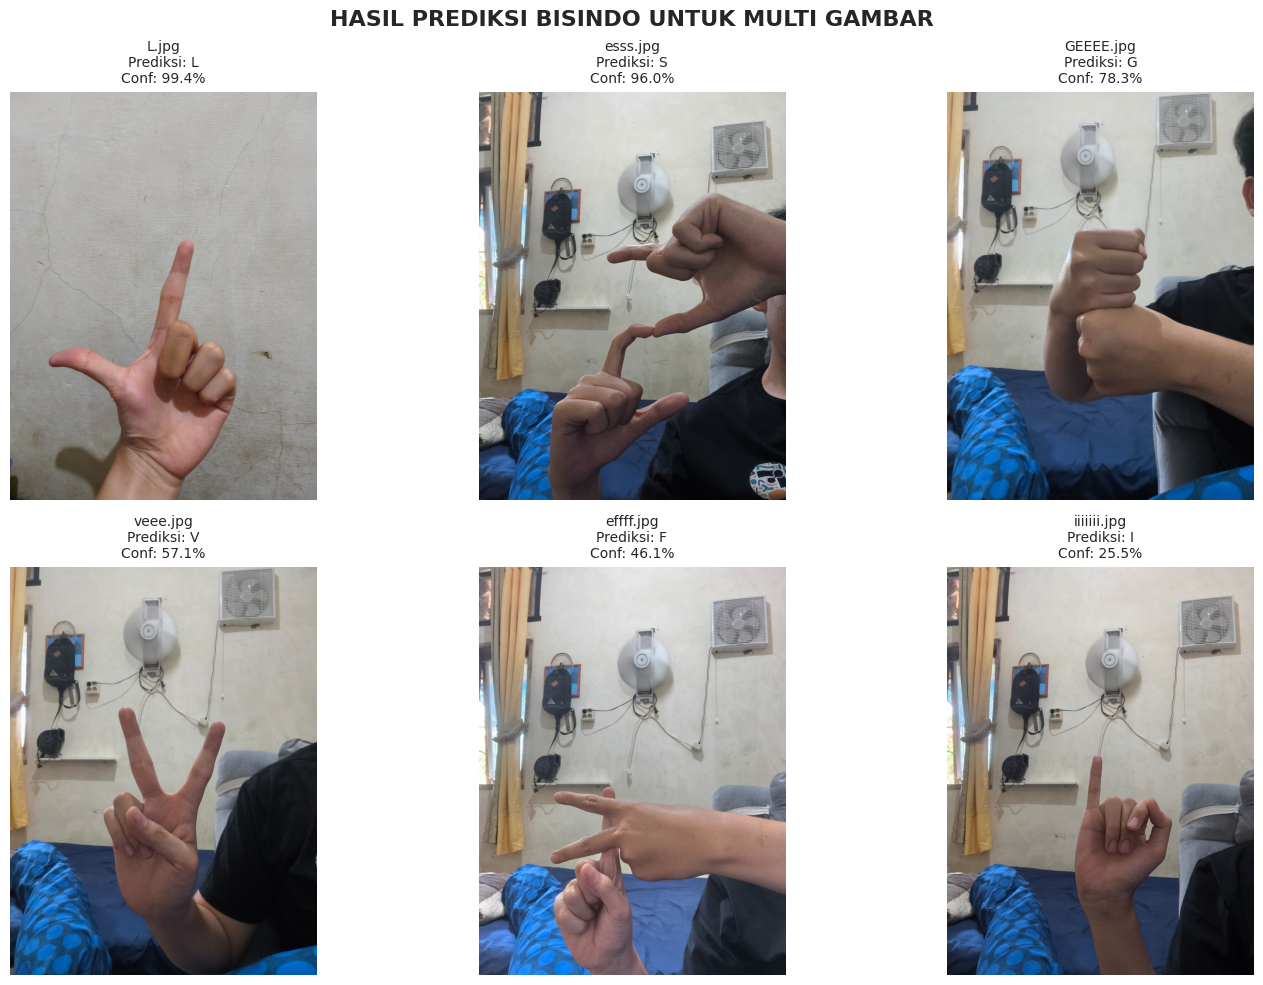


 TESTING SELESAI!


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os

# ============================================
# TESTING MULTI GAMBAR DARI DATASET
# ============================================

print(" TESTING MULTI GAMBAR DARI DATASET")
print("="*50)

# 1. Load model
model = keras.models.load_model('/kaggle/working/final_bisindo_model.keras')

# 2. Path folder berisi gambar yang akan diuji
test_folder = '/kaggle/input/data-testing/'  # Ganti dengan path folder Anda
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    print("Tidak ada gambar ditemukan di folder tersebut!")
    exit()

print(f"Ditemukan {len(image_files)} gambar untuk diuji:")
for img_file in image_files:
    print(f"- {img_file}")

# 3. Fungsi untuk memproses dan memprediksi satu gambar
def predict_image(img_path, model):
    # Baca gambar
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize ke ukuran yang diharapkan model
    img_resized = cv2.resize(img, (128, 128))
    
    # Normalisasi dan siapkan untuk prediksi
    img_input = np.expand_dims(img_resized / 255.0, axis=0)
    pred = model.predict(img_input, verbose=0)
    
    # Hasil
    idx = pred[0].argmax()
    conf = pred[0].max()
    huruf = chr(65 + idx)  # Convert 0→A, 1→B, 2→C, dst.
    
    return img, huruf, conf

# 4. Loop melalui semua gambar
results = []
for i, img_file in enumerate(image_files):
    img_path = os.path.join(test_folder, img_file)
    
    try:
        img, huruf, conf = predict_image(img_path, model)
        results.append({
            'file': img_file,
            'prediction': huruf,
            'confidence': conf,
            'image': img
        })
        
        print(f"\n [{i+1}/{len(image_files)}] HASIL PREDIKSI untuk {img_file}:")
        print(f"   • Prediksi: Huruf '{huruf}'")
        print(f"   • Confidence: {conf*100:.2f}%")
        
    except Exception as e:
        print(f"\nError saat memproses {img_file}: {str(e)}")

# 5. Tampilkan hasil dalam grid (maksimal 6 gambar per baris)
if results:
    n_cols = 3  # Jumlah kolom dalam grid
    n_rows = (len(results) + n_cols - 1) // n_cols  # Hitung jumlah baris
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    # Jika hanya 1 gambar, axes bukan array
    if len(results) == 1:
        axes = np.array([axes])
    
    # Flatten axes array untuk memudahkan iterasi
    axes = axes.flatten()
    
    for idx, result in enumerate(results):
        ax = axes[idx]
        
        # Tampilkan gambar asli
        ax.imshow(result['image'])
        
        # Tambahkan informasi prediksi
        title = f"{result['file']}\nPrediksi: {result['prediction']}\nConf: {result['confidence']*100:.1f}%"
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    # Matikan axes yang tidak terpakai
    for idx in range(len(results), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('HASIL PREDIKSI BISINDO UNTUK MULTI GAMBAR', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
print("\n TESTING SELESAI!")